In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

import keras_tuner as kt


In [2]:
df = pd.read_csv("titanic.csv")

df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

le = LabelEncoder()
df['Sex'] = le.fit_transform(df['Sex'])
df['Embarked'] = le.fit_transform(df['Embarked'])

X = df.drop('Survived', axis=1)
y = df['Survived']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


C:\Users\User\AppData\Local\Temp\ipykernel_60880\1799502024.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_60880\1799502024.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

In [3]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int('units_input', min_value=32, max_value=128, step=32),
        activation='relu',
        input_shape=(X_train.shape[1],)
    ))

    if hp.Boolean('use_hidden_layer'):
        model.add(Dense(
            units=hp.Int('units_hidden', min_value=32, max_value=128, step=32),
            activation='relu'
        ))

    model.add(Dense(1, activation='sigmoid'))

    lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [4]:
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='keras_tuner_bayes',
    project_name='titanic_adam_bayes'
)


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
tuner.search(X_train, y_train, epochs=30, validation_split=0.2, verbose=1)


Trial 10 Complete [00h 00m 03s]
val_accuracy: 0.8531468510627747

Best val_accuracy So Far: 0.8601398468017578
Total elapsed time: 00h 00m 34s


In [6]:
best_hp = tuner.get_best_hyperparameters(1)[0]
model = tuner.hypermodel.build(best_hp)

history = model.fit(X_train, y_train, epochs=30, validation_split=0.2, verbose=1)


Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7459 - loss: 0.5516 - val_accuracy: 0.8322 - val_loss: 0.3978
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8066 - loss: 0.4537 - val_accuracy: 0.8392 - val_loss: 0.3905
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8194 - loss: 0.4290 - val_accuracy: 0.8322 - val_loss: 0.3955
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8448 - loss: 0.3923 - val_accuracy: 0.8462 - val_loss: 0.3953
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8384 - loss: 0.3816 - val_accuracy: 0.8322 - val_loss: 0.4060
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8375 - loss: 0.4023 - val_accuracy: 0.8392 - val_loss: 0.3894
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8574 - loss: 0.3801 - val_accuracy: 0.7832 - val_loss: 0.4325
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8461 - loss: 0.3876 - val_accuracy: 0.8531 - val_loss:

In [7]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"✅ Test Accuracy (Bayesian): {accuracy:.4f}")

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print("📈 Classification Report:\n", classification_report(y_test, y_pred))
print("🧮 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8040 - loss: 0.4616 
✅ Test Accuracy (Bayesian): 0.8101
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
📈 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.86      0.84       105
           1       0.79      0.74      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179

🧮 Confusion Matrix:
 [[90 15]
 [19 55]]


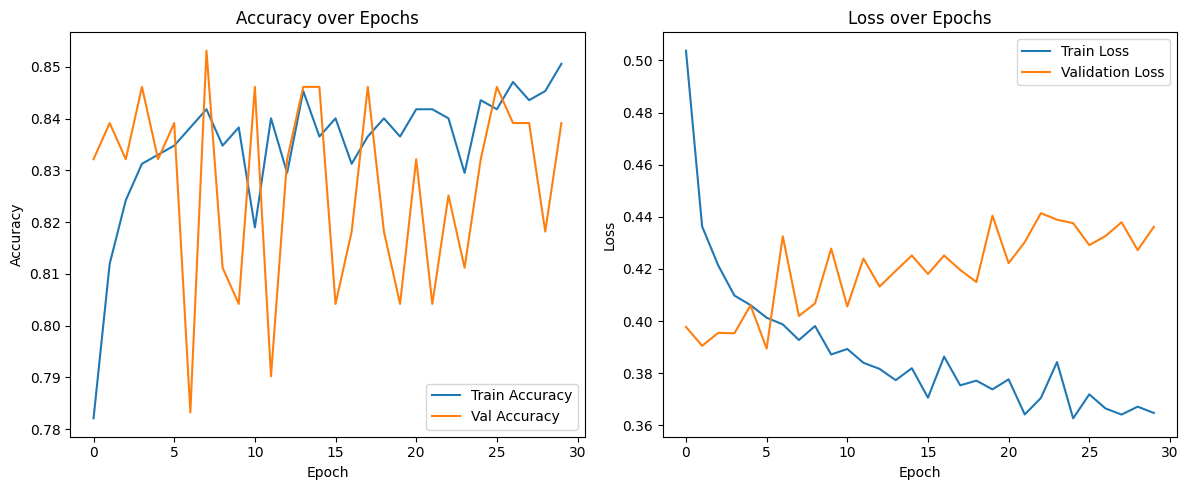

In [8]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


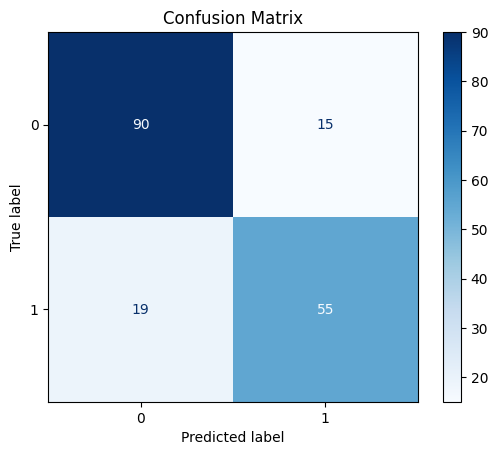

In [9]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()
